1
1
1
1
1
2
2
2
2
2
优化图表已保存至: Figure4_Final_Comparison_Zoomed.pdf


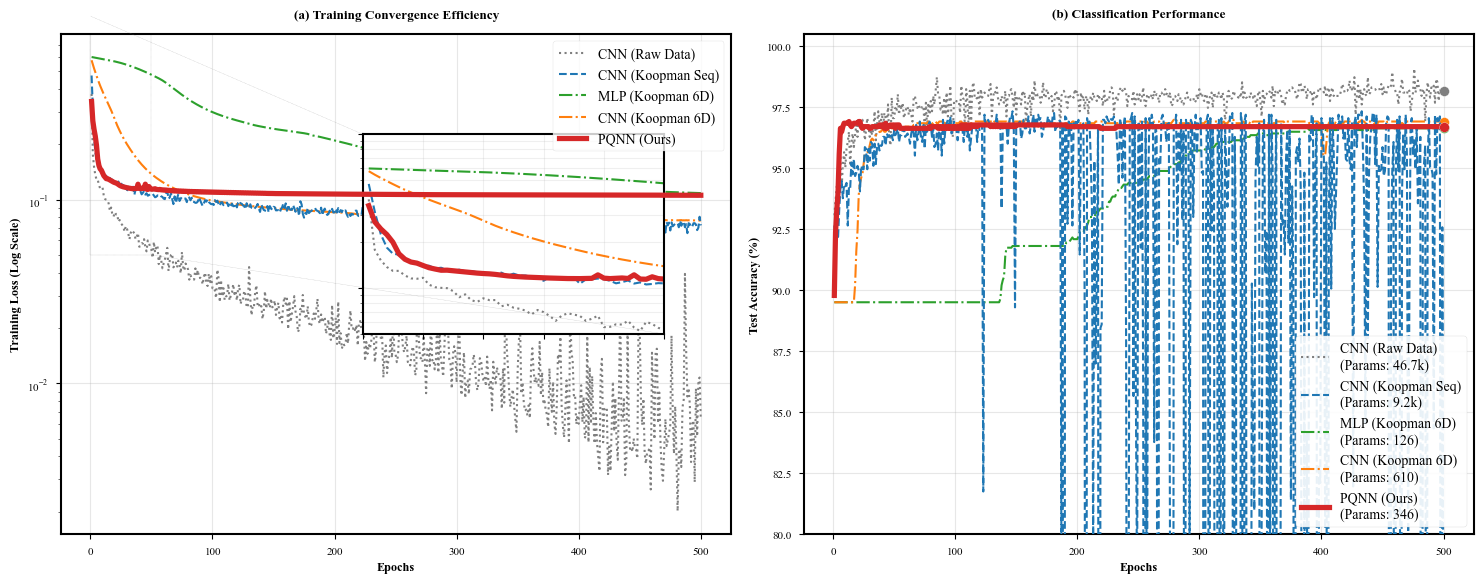

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import os

# ================= 配置 =================
LOG_CONFIG = [
    # 格式: ('文件名', '图例名称', '颜色', '线型', '线宽增益', 'Z-order')
    ('training_log_cnn_raw.npy',          'CNN (Raw Data)',       '#7f7f7f', ':',  1.0, 1),
    ('log_cnn_koopman.npy',      'CNN (Koopman Seq)',    '#1f77b4', '--', 1.0, 5),
    ('log_mlp_koopman_6d.npy',   'MLP (Koopman 6D)',     '#2ca02c', '-.', 1.0, 3),
    ('log_cnn_koopman_6d.npy',   'CNN (Koopman 6D)',     '#ff7f0e', '-.', 1.0, 3),
    ('log_pqnn.npy',             'PQNN (Ours)',          '#d62728', '-',  2.5, 10) # 最粗，最上层
]
SAVE_FIG = 'Figure4_Final_Comparison_Zoomed.pdf'
# =======================================

def plot_final_curves_zoomed():
    # 1. 读取数据
    data_store = []
    for fname, label, color, ls, lw_scale, z in LOG_CONFIG:
        if os.path.exists(fname):
            try:
                d = np.load(fname, allow_pickle=True).item()
                acc = d.get('test_acc', d.get('val_acc', []))
                loss = d.get('loss', [])
                epochs = d.get('epochs', range(1, len(loss)+1))
                params = d.get('params', 0)
                if len(acc) > 0:
                    # 简单的启发式判断：
                    # 如果这一组数据的最大值不超过 1.0，说明它是小数制 (0.xx)
                    # 我们把它乘以 100 统一转为百分制 (xx.xx%)
                    if max(acc) <= 1.0:
                        acc = [x * 100 for x in acc]
                        # print(f"  [Auto-Convert] {label} data scaled from 0-1 to 0-100%")
                        
                # 参数量格式化
                if params > 1e6: p_str = f"{params/1e6:.1f}M"
                elif params > 1000: p_str = f"{params/1000:.1f}k"
                else: p_str = f"{params}"
                
                data_store.append({
                    'label': label,
                    'full_label': f"{label}\n(Params: {p_str})",
                    'color': color, 'ls': ls, 'lw': 1.5 * lw_scale, 'z': z,
                    'loss': loss, 'acc': acc, 'epochs': epochs
                })
            except: pass

    if not data_store: return

    # 2. 设置风格
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        "font.family": "serif", "font.serif": ["Times New Roman"],
        "font.size": 12, "axes.grid": True, "grid.alpha": 0.3,
        "legend.fontsize": 10
    })

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # ==========================================
    # 子图 1: Loss Convergence (带局部放大)
    # ==========================================
    for d in data_store:
        print(1)
        ax1.plot(d['epochs'], d['loss'], label=d['label'], color=d['color'], 
                 linestyle=d['ls'], linewidth=d['lw'], zorder=d['z'])

    ax1.set_xlabel('Epochs', fontweight='bold')
    ax1.set_ylabel('Training Loss (Log Scale)', fontweight='bold')
    ax1.set_yscale('log')
    ax1.set_title('(a) Training Convergence Efficiency', fontweight='bold', pad=12)
    ax1.legend(loc='upper right')

    # --- 添加局部放大图 (Inset Zoom) ---
    # 在 ax1 内部画一个小图，位置在中心偏右 (x, y, width, height)
    axins = ax1.inset_axes([0.45, 0.4, 0.45, 0.4]) 
    
    for d in data_store:
        axins.plot(d['epochs'], d['loss'], color=d['color'], 
                   linestyle=d['ls'], linewidth=d['lw'])
    
    # 设置放大区域：关注前 50 轮
    axins.set_xlim(0, 50) 
    axins.set_ylim(0.05, 1.0) # 根据你的 Loss 数据范围微调这里！
    axins.set_yscale('log')
    axins.set_xticklabels('') # 去掉小图的刻度标签保持整洁
    axins.set_yticklabels('')
    axins.grid(True, which='both', alpha=0.2)
    
    # 画连接线
    mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec="0.5", linestyle=':')

    # ==========================================
    # 子图 2: Accuracy Performance (调整坐标轴)
    # ==========================================
    for d in data_store:
        print(2)
        ax2.plot(d['epochs'], d['acc'], label=d['full_label'], color=d['color'], 
                 linestyle=d['ls'], linewidth=d['lw'], zorder=d['z'])
        # 终点打点
        if len(d['epochs']) > 0:
            ax2.scatter(d['epochs'][-1], d['acc'][-1], color=d['color'], s=50, zorder=d['z']+1, edgecolors='white')

    ax2.set_xlabel('Epochs', fontweight='bold')
    ax2.set_ylabel('Test Accuracy (%)', fontweight='bold')
    ax2.set_title('(b) Classification Performance', fontweight='bold', pad=12)
    
    # 【关键修改】调整 Y 轴范围，聚焦 90% 以上
    # 自动检测数据的最小值，确保曲线不贴底
    all_accs = [val for d in data_store for val in d['acc']]
    min_acc = min(all_accs) if all_accs else 90
    y_bottom = max(80, min_acc - 2) # 最低展示到 80 或 数据最小值-2
    ax2.set_ylim(y_bottom, 100.5) 

    # 图例放右下角
    ax2.legend(loc='lower right', frameon=True, framealpha=0.9)

    plt.tight_layout()
    plt.savefig(SAVE_FIG, dpi=300, bbox_inches='tight')
    print(f"优化图表已保存至: {SAVE_FIG}")
    plt.show()

if __name__ == '__main__':
    plot_final_curves_zoomed()

正在读取日志文件...
  [Loaded] CNN (Raw Data)
  [Loaded] CNN (Koopman Seq)
  [Auto-Convert] MLP (Koopman 6D) scaled to %
  [Loaded] MLP (Koopman 6D)
  [Auto-Convert] CNN (Koopman 6D) scaled to %
  [Loaded] CNN (Koopman 6D)
  [Loaded] PQNN (Ours)

>>> 优化图表已保存至: Figure4_Final_Comparison_100Epochs.pdf


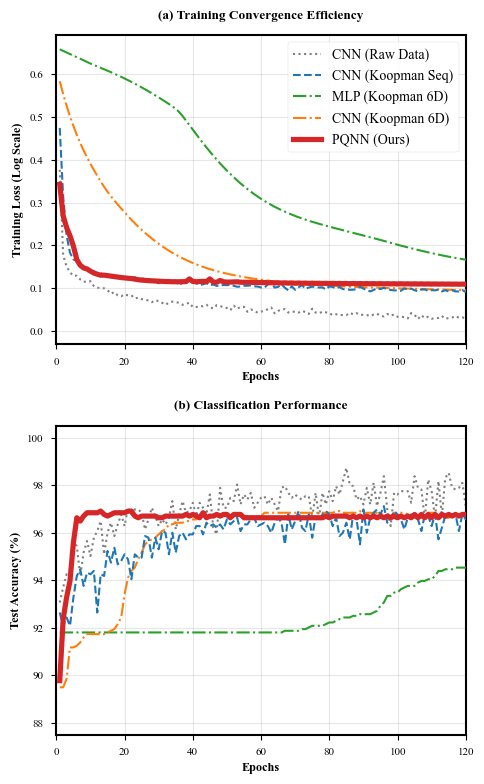

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ================= 配置 =================
LOG_CONFIG = [
    # 格式: ('文件名', '图例名称', '颜色', '线型', '线宽增益', 'Z-order')
    ('training_log_cnn_raw.npy',          'CNN (Raw Data)',       '#7f7f7f', ':',  1.0, 1),
    ('log_cnn_koopman.npy',      'CNN (Koopman Seq)',    '#1f77b4', '--', 1.0, 5),
    ('log_mlp_koopman_6d.npy',   'MLP (Koopman 6D)',     '#2ca02c', '-.', 1.0, 3),
    ('log_cnn_koopman_6d.npy',   'CNN (Koopman 6D)',     '#ff7f0e', '-.', 1.0, 3),
    ('log_pqnn.npy',             'PQNN (Ours)',          '#d62728', '-',  2.5, 10) # 最粗，最上层
]
SAVE_FIG = 'Figure4_Final_Comparison_100Epochs.pdf'
# =======================================

def plot_final_curves_100():
    # 1. 读取数据
    data_store = []
    print("正在读取日志文件...")
    for fname, label, color, ls, lw_scale, z in LOG_CONFIG:
        if os.path.exists(fname):
            try:
                d = np.load(fname, allow_pickle=True).item()
                
                # 读取 accuracy
                acc = d.get('test_acc', d.get('val_acc', []))
                loss = d.get('loss', [])
                epochs = d.get('epochs', range(1, len(loss)+1))
                params = d.get('params', 0)
                
                # --- 自动统一量纲 (0-1 -> 0-100%) ---
                if len(acc) > 0 and max(acc) <= 1.0:
                    acc = [x * 100 for x in acc]
                    print(f"  [Auto-Convert] {label} scaled to %")
                
                # 参数量格式化
                if params > 1e6: p_str = f"{params/1e6:.1f}M"
                elif params > 1000: p_str = f"{params/1000:.1f}k"
                else: p_str = f"{params}"
                
                data_store.append({
                    'label': label,
                    'full_label': f"{label}\n(Params: {p_str})",
                    'color': color, 'ls': ls, 'lw': 1.5 * lw_scale, 'z': z,
                    'loss': loss, 'acc': acc, 'epochs': epochs
                })
                print(f"  [Loaded] {label}")
            except Exception as e:
                print(f"  [Error] {fname}: {e}")

    if not data_store:
        print("未找到数据文件。")
        return

    # 2. 设置风格
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        "font.family": "serif", "font.serif": ["Times New Roman"],
        "font.size": 12, "axes.grid": True, "grid.alpha": 0.3,
        "legend.fontsize": 10
    })

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 8))

    # ==========================================
    # 子图 1: Loss Convergence (无插图，限前100轮)
    # ==========================================
    for d in data_store:
        ax1.plot(d['epochs'], d['loss'], label=d['label'], color=d['color'], 
                 linestyle=d['ls'], linewidth=d['lw'], zorder=d['z'])

    ax1.set_xlabel('Epochs', fontweight='bold')
    ax1.set_ylabel('Training Loss (Log Scale)', fontweight='bold')
    # ax1.set_yscale('log')
    ax1.set_title('(a) Training Convergence Efficiency', fontweight='bold', pad=12)
    
    # 【修改点 1】设置 X 轴范围为 0-100
    ax1.set_xlim(0, 120)
    
    ax1.legend(loc='upper right', frameon=True, framealpha=0.9)

    # ==========================================
    # 子图 2: Accuracy Performance (限前100轮)
    # ==========================================
    for d in data_store:
        ax2.plot(d['epochs'], d['acc'], label=d['full_label'], color=d['color'], 
                 linestyle=d['ls'], linewidth=d['lw'], zorder=d['z'])
        
        # 仅当该模型的 epoch 在 0-100 范围内结束时，才画终点圆点
        # 如果模型跑了 500 轮，终点在 100 以外，就不画点，避免误导
        final_epoch = d['epochs'][-1]
        if final_epoch <= 120:
            ax2.scatter(final_epoch, d['acc'][-1], color=d['color'], s=50, zorder=d['z']+1, edgecolors='white')

    ax2.set_xlabel('Epochs', fontweight='bold')
    ax2.set_ylabel('Test Accuracy (%)', fontweight='bold')
    ax2.set_title('(b) Classification Performance', fontweight='bold', pad=12)
    
    # 【修改点 2】设置 X 轴范围为 0-100
    ax2.set_xlim(0, 120)

    # 自动调整 Y 轴 (聚焦高精度区域)
    # 计算所有模型在前 100 轮内的最小值，避免 Y 轴从 0 开始
    try:
        visible_accs = []
        for d in data_store:
            # 只取前 100 轮的数据来决定 Y 轴下限
            limit = min(100, len(d['acc']))
            visible_accs.extend(d['acc'][:limit])
        
        if visible_accs:
            y_min = min(visible_accs)
            # 稍微留点余量，最低不少于 80%
            y_bottom = max(80, y_min - 2)
            ax2.set_ylim(y_bottom, 100.5)
    except:
        ax2.set_ylim(90, 100.5)

    # 图例放右下角
    # ax2.legend(loc='lower right', frameon=True, framealpha=0.9)

    plt.tight_layout()
    plt.savefig(SAVE_FIG, dpi=300, bbox_inches='tight')
    print(f"\n>>> 优化图表已保存至: {SAVE_FIG}")
    plt.show()

if __name__ == '__main__':
    plot_final_curves_100()